# Validating results with fluorescence data



Data from the seqFISH (transcriptomic fluorescence assays) paper "High-resolution spatial multi-omics reveals cell-type specific nuclear compartments" by Takei *et al.* (2023).

Preprint: https://www.biorxiv.org/content/10.1101/2023.05.07.539762v1
'Raw' Data: https://outlook.office.com/mail/safelink.html?url=https://zenodo.org/record/7693825&corid=cddd4553-1e93-1bbb-63f9-c163d915e8dc 



In [3]:
# System
import os,sys
sys.path.insert(0,'../../BIVI/')
sys.path.insert(0,'../../BIVI/BIVI')



import numpy as np
import torch
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix

# colors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

# single cell
import anndata
import scanpy as sc

# import biVI scripts
import biVI


# reproducibility -- set random seeds
torch.manual_seed(8675309);

/home/tara/temp_git2/CGCCP_2023/Manuscript/analysis/../../BIVI/BIVI


In [55]:
def nd(matrix):
    return(np.array(matrix).flatten())

# Verifying *biVI* inferred burst sizes using seqFISH data

This notebook processes and analyzes fluorescent transcriptomic data from this recent pre-print from Elowitz lab: https://www.biorxiv.org/content/10.1101/2023.05.07.539762v1.abstract , which assayed intron (transcription active sites, TAS) spot and intensity and mRNA spots for more than 1,000 genes in several hundred cultured mouse embryonic stem cells (E14 cells). 





In [56]:
# functions 

def get_burst_size_per_cell(count_df):
    ''' Return cell by gene count matrix with burst sizes, which is the average of intensity of intronic spots
        observed per gene per cell. 
    '''
    
    num_genes = len(count_df['geneID'].unique())
    num_cells = len(count_df['unique_id'].unique())
    df_ = count_df.groupby(['unique_id','geneID'])['intensity'].mean().reset_index(name='mean_burst_size')
    
    genes = count_df['geneID'].unique()
    cells = count_df['unique_id'].unique()
    genes_long = list(genes)*len(cells)

    cells_long = []

    for c in cells:
        cells_long+=[c]*len(genes)
    
    all_genes_cells = pd.DataFrame({'geneID': genes_long,'unique_id' : cells_long})
    df_merge = all_genes_cells.merge(df_,left_on=['geneID','unique_id'],right_on=['geneID','unique_id'],
                                how='left').fillna(0)
    
    count_array = np.zeros((num_cells,num_genes))
    
    for i,ID in enumerate(count_df['unique_id'].unique()):
        counts_ = df_merge[df_merge['unique_id']==ID]
        count_array[i,:] = counts_['mean_burst_size']
    
        
    return(count_array)


def get_count_matrix(count_df):
    ''' Given a count data frame with each count, return cell by gene matrix 
    with number of times each gene was observed in each cell.
    '''
    
    num_genes = len(count_df['geneID'].unique())
    num_cells = len(count_df['unique_id'].unique())
    df_ = count_df.groupby(['unique_id','geneID']).size().reset_index(name='counts')
    
    genes = count_df['geneID'].unique()
    cells = count_df['unique_id'].unique()
    genes_long = list(genes)*len(cells)

    cells_long = []

    for c in cells:
        cells_long+=[c]*len(genes)
    
    all_genes_cells = pd.DataFrame({'geneID': genes_long,'unique_id' : cells_long})
    df_merge = all_genes_cells.merge(df_,left_on=['geneID','unique_id'],right_on=['geneID','unique_id'],
                                how='left').fillna(0)
    
    count_array = np.zeros((num_cells,num_genes))
    
    for i,ID in enumerate(count_df['unique_id'].unique()):
        counts_ = df_merge[df_merge['unique_id']==ID]
        count_array[i,:] = counts_['counts']
    
        
    return(count_array)


def get_adjusted_count_matrix(count_df):
    ''' Return cell by gene count matrix with intronic counts adjusted by intensity value.
    '''
    
    count_df['adjusted_intron_counts'] = np.ceil(count_df['intensity'].values)

    num_genes = len(count_df['geneID'].unique())
    num_cells = len(count_df['unique_id'].unique())
    df_ = count_df.groupby(['unique_id','geneID'])['adjusted_intron_counts'].sum().reset_index(name='adjusted_intron_counts')
    
    genes = count_df['geneID'].unique()
    cells = count_df['unique_id'].unique()
    genes_long = list(genes)*len(cells)

    cells_long = []

    for c in cells:
        cells_long+=[c]*len(genes)
    
    all_genes_cells = pd.DataFrame({'geneID': genes_long,'unique_id' : cells_long})
    df_merge = all_genes_cells.merge(df_,left_on=['geneID','unique_id'],right_on=['geneID','unique_id'],
                                how='left').fillna(0)
    
    count_array = np.zeros((num_cells,num_genes))
    
    for i,ID in enumerate(count_df['unique_id'].unique()):
        counts_ = df_merge[df_merge['unique_id']==ID]
        count_array[i,:] = counts_['adjusted_intron_counts']
    
        
    return(count_array)

In [57]:
!ls ../data

allen  battich	desai  README  simulated_data  takei


In [58]:
# load in data

count_dir = '../data/takei/'
es_intron_raw = pd.read_csv(os.path.join(count_dir,'E14-replicate1-intron-seqFISH-ch2.csv'))
es_exon_raw = pd.read_csv(os.path.join(count_dir,'E14-replicate1-mRNA-seqFISH-ch1.csv'))

es_intron_raw2 = pd.read_csv(os.path.join(count_dir,'E14-replicate2-intron-seqFISH-ch2.csv'))
es_exon_raw2 = pd.read_csv(os.path.join(count_dir,'E14-replicate2-mRNA-seqFISH-ch1.csv'))


# add unique ids
es_intron_raw['unique_id'] = 'cell' + es_intron_raw['cellID'].astype(str)+'_fov'+es_intron_raw['fov'].astype('str')
es_exon_raw['unique_id'] = 'cell' + es_exon_raw ['cellID'].astype(str)+'_fov'+es_exon_raw['fov'].astype('str')
es_intron_raw2['unique_id'] = 'cell' + es_intron_raw2['cellID'].astype(str)+'_fov'+es_intron_raw2['fov'].astype('str')
es_exon_raw2['unique_id'] = 'cell' + es_exon_raw2['cellID'].astype(str)+'_fov'+es_exon_raw2['fov'].astype('str')

# Data exploration

In [59]:
# how many genes are observed for introns/exons in rep1 and rep2
a = len(es_intron_raw['geneID'].unique()) 
print(f'There were {a} TAS genes in E14 rep1')
a = len(es_intron_raw2['geneID'].unique()) 
print(f'There were {a} TAS genes in E14 rep2')
a = len(es_exon_raw['geneID'].unique()) 
print(f'There were {a} exon genes in E14 rep1')
a = len(es_exon_raw2['geneID'].unique()) 
print(f'There were {a} exon genes in E14 rep2')

# how many cells were observed for introns/exons in rep1 and rep2
a = len(es_intron_raw['unique_id'].unique()) 
print(f'There were {a} TAS cells in E14 rep1')
a = len(es_intron_raw2['unique_id'].unique()) 
print(f'There were {a} TAS cells in E14 rep2')
a = len(es_exon_raw['unique_id'].unique()) 
print(f'There were {a} exon cells in E14 rep1')
a = len(es_exon_raw2['unique_id'].unique()) 
print(f'There were {a} exon cells in E14 rep2')

There were 17683 TAS genes in E14 rep1
There were 17682 TAS genes in E14 rep2
There were 4096 exon genes in E14 rep1
There were 4096 exon genes in E14 rep2
There were 523 TAS cells in E14 rep1
There were 553 TAS cells in E14 rep2
There were 523 exon cells in E14 rep1
There were 553 exon cells in E14 rep2


In [105]:
# ALL burst sizes, for all introns
es_burst_sizes_all_1 = get_burst_size_per_cell(es_intron_raw)
es_burst_sizes_all_2 = get_burst_size_per_cell(es_intron_raw2)

In [ ]:
# es_intron_counts1_all = get_count_matrix(es_intron_raw)
# es_intron_counts2_all = get_count_matrix(es_intron_raw2)
# es_exon_counts1_all = get_count_matrix(es_exon_raw)
# es_exon_counts2_all = get_count_matrix(es_exon_raw2)

# es_adjusted_intron_counts1_all = get_adjusted_count_matrix(es_intron_raw)
# es_adjusted_intron_counts2_all = get_adjusted_count_matrix(es_intron_raw2)

In [106]:
es_bs_dict_1 = {'burst_size' : es_burst_sizes_all_1,
           'gene_name' : es_intron_raw['geneID'].unique(),
           'cell_id' : es_intron_raw['unique_id'].unique(),
           'adj_intron_counts' : es_adjusted_intron_counts1_all,
           'intron_counts' : es_intron_counts1_all, 
           'exon_counts' : es_exon_counts1_all, }

es_bs_dict_2 = {'burst_size' : es_burst_sizes_all_2,
           'gene_name' : es_intron_raw2['geneID'].unique(),
           'adj_intron_counts' : es_adjusted_intron_counts2_all,
           'intron_counts' : es_intron_counts2_all, 
           'exon_counts' : es_exon_counts2_all, }

In [107]:
# save! 
with open('../results/E14_rep1_seqFISH_burst_sizes_all','wb') as file:
    pickle.dump(es_bs_dict_1,file,protocol=pickle.HIGHEST_PROTOCOL)
with open('../results/E14_rep2_seqFISH_burst_sizes_all','wb') as file:
    pickle.dump(es_bs_dict_2,file,protocol=pickle.HIGHEST_PROTOCOL)

Let us look at how the read distributions for genes with both observed TAS spots and exon spots look.

In [ ]:
len(es_intron_raw2['geneID'].unique())

In [60]:
# subset reads
mask = es_exon_raw['geneID'].isin(es_intron_raw['geneID'].unique())
es_exon_subset1 = es_exon_raw[mask]

mask = es_intron_raw['geneID'].isin(es_exon_raw['geneID'].unique())
es_intron_subset1 = es_intron_raw[mask]

mask = es_exon_raw2['geneID'].isin(es_intron_raw2['geneID'].unique())
es_exon_subset2 = es_exon_raw2[mask]

mask = es_intron_raw2['geneID'].isin(es_exon_raw2['geneID'].unique())
es_intron_subset2 = es_intron_raw2[mask]


## Histograms of intensities

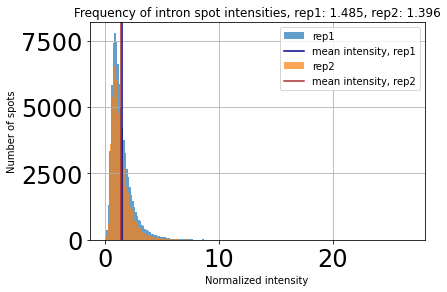

In [8]:
plt.hist(es_intron_subset1['intensity'],bins=200,alpha=0.7,label='rep1')
plt.axvline(np.mean(es_intron_subset1['intensity']),label='mean intensity, rep1',color='darkblue')
plt.hist(es_intron_subset2['intensity'],bins=200,alpha=0.7,label='rep2')
plt.axvline(np.mean(es_intron_subset2['intensity']),color='brown',label='mean intensity, rep2')
plt.ylabel('Number of spots')
plt.xlabel('Normalized intensity')
plt.grid()
plt.legend()
mean1 = np.mean(es_intron_subset1['intensity'])
mean2 = np.mean(es_intron_subset2['intensity'])
plt.title(f'Frequency of intron spot intensities, rep1: {mean1:.3f}, rep2: {mean2:.3f}');

### Histogram intensities > 0.5 um away from chromosomes


Yodai Takei (first author) suggested using only spots < 0.5 um away from chromosomes as to reduce noise. However, their analysis is particularly interested in transcription active sites (TASs), which are at DNA so near chromosome regions; we want, however, to get approximate counts for introns, regardless of if they are actively being transcribed or not. We thus consider all intron spots. Further, the distributions of intensities look very similar for chromosome far and chromosome close intron/TAS spots, leading us to believe that there is not significantly increased noise in the chromosome far intron spots. 





In [9]:
es_intron_subset1_far = es_intron_subset1[es_intron_subset1['min_dist']>0.5]
es_intron_subset2_far = es_intron_subset2[es_intron_subset2['min_dist']>0.5]

es_intron_subset1_close = es_intron_subset1[es_intron_subset1['min_dist']<=0.5]
es_intron_subset2_close = es_intron_subset2[es_intron_subset2['min_dist']<=0.5]

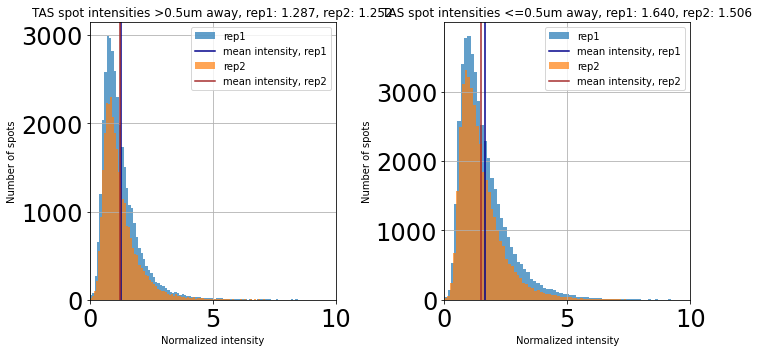

In [10]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(es_intron_subset1_far['intensity'],bins=200,alpha=0.7,label='rep1')
ax[0].axvline(np.mean(es_intron_subset1_far['intensity']),label='mean intensity, rep1',color='darkblue')
ax[0].hist(es_intron_subset2_far['intensity'],bins=200,alpha=0.7,label='rep2')
ax[0].axvline(np.mean(es_intron_subset2_far['intensity']),color='brown',label='mean intensity, rep2')
ax[0].set_ylabel('Number of spots')
ax[0].set_xlabel('Normalized intensity')
ax[0].grid()
ax[0].legend()
ax[0].set_xlim(0,10)
mean1 = np.mean(es_intron_subset1_far['intensity'])
mean2 = np.mean(es_intron_subset2_far['intensity'])
ax[0].set_title(f'TAS spot intensities >0.5um away, rep1: {mean1:.3f}, rep2: {mean2:.3f}');

ax[1].hist(es_intron_subset1_close['intensity'],bins=200,alpha=0.7,label='rep1')
ax[1].axvline(np.mean(es_intron_subset1_close['intensity']),label='mean intensity, rep1',color='darkblue')
ax[1].hist(es_intron_subset2_close['intensity'],bins=200,alpha=0.7,label='rep2')
ax[1].axvline(np.mean(es_intron_subset2_close['intensity']),color='brown',label='mean intensity, rep2')
ax[1].set_ylabel('Number of spots')
ax[1].set_xlabel('Normalized intensity')
ax[1].grid()
ax[1].legend()
ax[1].set_xlim(0,10)
mean1 = np.mean(es_intron_subset1_close['intensity'])
mean2 = np.mean(es_intron_subset2_close['intensity'])
ax[1].set_title(f'TAS spot intensities <=0.5um away, rep1: {mean1:.3f}, rep2: {mean2:.3f}')
plt.tight_layout();

# Calculate counts

In [87]:
es_intron_counts1 = get_count_matrix(es_intron_subset1)
es_intron_counts2 = get_count_matrix(es_intron_subset2)
es_exon_counts1 = get_count_matrix(es_exon_subset1)
es_exon_counts2 = get_count_matrix(es_exon_subset2)

In [88]:
es_adjusted_intron_counts1 = get_adjusted_count_matrix(es_intron_subset1)
es_adjusted_intron_counts2 = get_adjusted_count_matrix(es_intron_subset2)

<ipython-input-56-0b16cb214df5>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['adjusted_intron_counts'] = np.ceil(count_df['intensity'].values)
<ipython-input-56-0b16cb214df5>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['adjusted_intron_counts'] = np.ceil(count_df['intensity'].values)


In [52]:
print(len(np.mean(es_adjusted_intron_counts1_all,axis=0)),len(np.mean(es_adjusted_intron_counts2_all,axis=0)))
print(len(np.mean(es_exon_counts1_all,axis=0)),len(np.mean(es_exon_counts2_all,axis=0)))

17683 17682
4096 4096


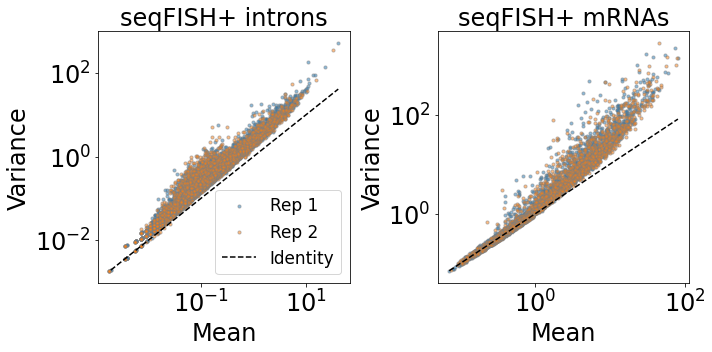

In [78]:
# plot variance vs. mean for intron (adjusted) and exon counts

save_path = None
fs = 24
fig,ax = plt.subplots(1,2,figsize=(10,5))



ax[0].scatter(np.mean(es_adjusted_intron_counts1_all,axis=0),np.var(es_adjusted_intron_counts1_all,axis=0),
              s=10,alpha=0.5,label='Rep 1',color=sns.color_palette("tab10")[0],edgecolor='gray')
ax[0].scatter(np.mean(es_adjusted_intron_counts2_all,axis=0),np.var(es_adjusted_intron_counts2_all,axis=0),
              s=10,alpha=0.5,label='Rep 2',color=sns.color_palette("tab10")[1],edgecolor='gray')
ax[0].set_title(f'seqFISH+ introns',fontsize=fs)
ax[0].set_xlabel('Mean',fontsize=fs)
ax[0].set_ylabel('Variance',fontsize=fs)
plot_ = [np.min(np.mean(es_adjusted_intron_counts1_all,axis=0)),np.max(np.mean(es_adjusted_intron_counts1_all,axis=0))]
ax[0].plot(plot_,plot_,color='k',linestyle='--',label='Identity')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(fontsize=17,loc='lower right');

ax[1].scatter(np.mean(es_exon_counts1_all,axis=0),np.var(es_exon_counts1_all,axis=0),
          s=10,alpha=0.5,label='Rep 1',color=sns.color_palette("tab10")[0],edgecolor='gray')
ax[1].scatter(np.mean(es_exon_counts2_all,axis=0),
              np.var(es_exon_counts2_all,axis=0),
              s=10,alpha=0.5,label='Rep 2',color=sns.color_palette("tab10")[1],edgecolor='gray')
ax[1].set_title(f'seqFISH+ mRNAs',fontsize=fs)
ax[1].set_xlabel('Mean',fontsize=fs)
ax[1].set_ylabel('Variance',fontsize=fs)
plot_ = [np.min(np.mean(es_exon_counts1_all,axis=0)),np.max(np.mean(es_exon_counts1_all,axis=0))]
ax[1].plot(plot_,plot_,color='k',linestyle='--',label='Identity')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].legend(fontsize=20);


plt.tight_layout();

if save_path != None:
    plt.savefig('../results/seqFISH_mean_vs_variance_no_raw',dpi=450,bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: './figures/seqFISH_mean_vs_variance.png'

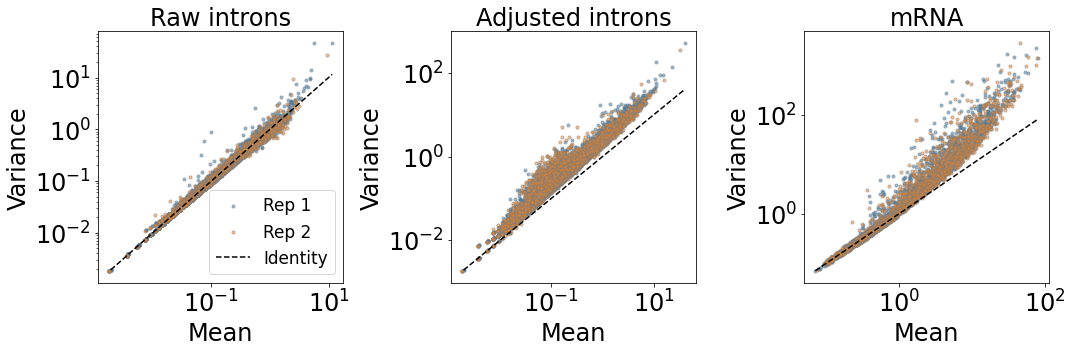

In [72]:
# plot variance vs. mean for intron (adjusted and non-adjusted) and exon counts

save_path = True
fs = 24
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(np.mean(es_intron_counts1_all,axis=0),np.var(es_intron_counts1_all,axis=0),
              s=10,alpha=0.5,label='Rep 1',color=sns.color_palette("tab10")[0],edgecolor='gray')
ax[0].scatter(np.mean(es_intron_counts2_all,axis=0),np.var(es_intron_counts2_all,axis=0),
              s=10,alpha=0.5,label='Rep 2',color=sns.color_palette("tab10")[1],edgecolor='gray')
ax[0].set_title(f'Raw introns',fontsize=fs)
ax[0].set_xlabel('Mean',fontsize=fs)
ax[0].set_ylabel('Variance',fontsize=fs)

plot_ = [np.min(np.mean(es_intron_counts1_all,axis=0)),np.max(np.mean(es_intron_counts1_all,axis=0))]
ax[0].plot(plot_,plot_,color='k',linestyle='--',label='Identity')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(fontsize=17,loc='lower right');

ax[1].scatter(np.mean(es_adjusted_intron_counts1_all,axis=0),np.var(es_adjusted_intron_counts1_all,axis=0),
              s=10,alpha=0.5,label='Rep 1',color=sns.color_palette("tab10")[0],edgecolor='gray')
ax[1].scatter(np.mean(es_adjusted_intron_counts2_all,axis=0),np.var(es_adjusted_intron_counts2_all,axis=0),
              s=10,alpha=0.5,label='Rep 2',color=sns.color_palette("tab10")[1],edgecolor='gray')
ax[1].set_title(f'Adjusted introns',fontsize=fs)
ax[1].set_xlabel('Mean',fontsize=fs)
ax[1].set_ylabel('Variance',fontsize=fs)
plot_ = [np.min(np.mean(es_adjusted_intron_counts1_all,axis=0)),np.max(np.mean(es_adjusted_intron_counts1_all,axis=0))]
ax[1].plot(plot_,plot_,color='k',linestyle='--',label='Identity')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].legend(fontsize=fs);

ax[2].scatter(np.mean(es_exon_counts1_all,axis=0),np.var(es_exon_counts1_all,axis=0),
              s=10,alpha=0.5,label='Rep 1',color=sns.color_palette("tab10")[0],edgecolor='gray')
ax[2].scatter(np.mean(es_exon_counts2_all,axis=0),
              np.var(es_exon_counts2_all,axis=0),
              s=10,alpha=0.5,label='Rep 2',color=sns.color_palette("tab10")[1],edgecolor='gray')
ax[2].set_title(f'mRNA',fontsize=fs)
ax[2].set_xlabel('Mean',fontsize=fs)
ax[2].set_ylabel('Variance',fontsize=fs)
plot_ = [np.min(np.mean(es_exon_counts1_all,axis=0)),np.max(np.mean(es_exon_counts1_all,axis=0))]
ax[2].plot(plot_,plot_,color='k',linestyle='--',label='Identity')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
# ax[2].legend(fontsize=20);


plt.tight_layout();

if save_path != None:
    plt.savefig('./figures/seqFISH_mean_vs_variance',dpi=450,bbox_inches='tight')



In [ ]:
# # exon counts per gene
fgi,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(np.sum(es_intron_counts1,axis=1),alpha=0.5,bins=50,label='rep1',color='blue')
ax[0].hist(np.sum(es_intron_counts2,axis=1),alpha=0.5,bins=50,label='rep2',color='gray')
# ax[0].hist(np.sum(intron_counts1,axis=1),alpha=0.5,bins=50,label='intron counts')
ax[0].set_title('Intron counts per cell')
ax[0].set_xlabel('# intron counts')
ax[0].set_ylabel('# cells')
ax[0].legend();

ax[1].hist(np.sum(es_exon_counts1,axis=1),alpha=0.5,bins=50,color='red',label='rep1')
ax[1].hist(np.sum(es_exon_counts2,axis=1),alpha=0.5,bins=50,color='darkred',label='rep2')
# ax[0].hist(np.sum(intron_counts1,axis=1),alpha=0.5,bins=50,label='intron counts')
ax[1].set_title('mRNA/Exon counts per cell')
ax[1].set_xlabel('# exon counts')
ax[1].set_ylabel('# cells')
ax[1].legend()

plt.tight_layout();

In [ ]:
# exon counts per gene
fgi,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(es_intron_counts1.flatten(),alpha=0.5,bins=50,label='rep1',color='blue')
ax[0].hist(es_intron_counts2.flatten(),alpha=0.5,bins=50,label='rep2',color='gray')
# ax[0].hist(np.sum(intron_counts1,axis=1),alpha=0.5,bins=50,label='intron counts')
ax[0].set_title('Intron Counts per gene')
ax[0].set_xlabel('# intron counts')
ax[0].set_ylabel('# genes')
ax[0].legend();

ax[1].hist(es_exon_counts1.flatten(),alpha=0.5,bins=50,color='red',label='rep1')
ax[1].hist(es_exon_counts2.flatten(),alpha=0.5,bins=50,color='darkred',label='rep2')
# ax[0].hist(np.sum(intron_counts1,axis=1),alpha=0.5,bins=50,label='intron counts')
ax[1].set_title('mRNA/Exon counts per gene')
ax[1].set_xlabel('# exon counts')
ax[1].set_ylabel('# genes')
ax[1].legend()

plt.tight_layout();

In [ ]:
# # exon counts per gene
fgi,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(es_adjusted_intron_counts1.flatten(),alpha=0.5,bins=50,label='rep1',color='blue')
ax[0].hist(es_adjusted_intron_counts2.flatten(),alpha=0.5,bins=50,label='rep2',color='gray')
# ax[0].hist(np.sum(intron_counts1,axis=1),alpha=0.5,bins=50,label='intron counts')
ax[0].set_title('Adjusted Intron Counts per gene')
ax[0].set_xlabel('# adjusted intron counts')
ax[0].set_ylabel('# genes')
ax[0].set_xlim(-1,10)
ax[0].legend();

ax[1].hist(es_exon_counts1.flatten(),alpha=0.5,bins=50,color='red',label='rep1')
ax[1].hist(es_exon_counts2.flatten(),alpha=0.5,bins=50,color='darkred',label='rep2')
# ax[0].hist(np.sum(intron_counts1,axis=1),alpha=0.5,bins=50,label='intron counts')
ax[1].set_title('mRNA/Exon counts per gene')
ax[1].set_xlabel('# exon counts')
ax[1].set_ylabel('# genes')
ax[1].legend()

plt.tight_layout();

-----



# Fit biVI to adjusted intron counts




In [89]:
# get subset burst sizes
es_burst_sizes_subset1 = get_burst_size_per_cell(es_intron_subset1)
es_burst_sizes_subset2 = get_burst_size_per_cell(es_intron_subset2)

In [90]:
# create anndata, first with rep1

adata_u = anndata.AnnData(csr_matrix(es_adjusted_intron_counts1, dtype=np.float32))
# adata_u.obs_names = es_intron['unique_id'].unique()
# adata_u.var_names = es_intron['geneID'].unique()

adata_s = anndata.AnnData(csr_matrix(es_exon_counts1, dtype=np.float32))
# adata_s.obs_names = es_intron['unique_id'].unique()
# adata_s.var_names = es_intron['geneID'].unique()

adata_u.var['Spliced']   = False
adata_s.var['Spliced'] =  True

In [91]:
adata_1 = anndata.concat([adata_u,adata_s],axis=1)
adata_1.layers["counts"] = adata_1.X.copy() # preserve counts

# Update obs,var
adata_1.obs = adata_u.obs.copy()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [92]:
# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata_1,layer="counts")

In [93]:
model_args = {    'n_latent'     : 10,
                  'n_layers'     : 3,
                  'dispersion'   : 'gene',
                  'n_hidden'     : 128,
                  'dropout_rate' :  0.1,
                  'log_variational'    :  True,
                  'latent_distribution':  'normal',
                  'THETA_IS' : 'NAS_SHAPE'
                  }

# training plan parameters
max_epochs = 400

plan_kwargs = {'lr' : 0.001,
               'n_epochs_kl_warmup' : max_epochs/2,
                }

In [94]:
model = biVI.biVI(adata_1,mode='Bursty',**model_args)

{'n_input': 2232, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


In [95]:
model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [01:16<00:00,  5.38it/s, loss=2.62e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:16<00:00,  5.24it/s, loss=2.62e+03, v_num=1]


In [96]:
# and same for rep2

adata_u2 = anndata.AnnData(csr_matrix(es_adjusted_intron_counts2, dtype=np.float32))
adata_s2 = anndata.AnnData(csr_matrix(es_exon_counts2, dtype=np.float32))
adata_u2.var['Spliced']   = False
adata_s2.var['Spliced'] = True
adata_2 = anndata.concat([adata_u2,adata_s2],axis=1)
adata_2.layers["counts"] = adata_2.X.copy() # preserve counts
adata_2.obs = adata_u2.obs.copy()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [97]:
# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata_2,layer="counts")

In [98]:
model2 = biVI.biVI(adata_2,mode='Bursty',**model_args)

{'n_input': 2230, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


In [99]:
model2.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [01:15<00:00,  5.36it/s, loss=2.58e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:15<00:00,  5.27it/s, loss=2.58e+03, v_num=1]


# Investigate returned parameters

In [100]:
# get parameters
parameters = model.get_likelihood_parameters()
parameters2 = model2.get_likelihood_parameters()

Bursty mode, getting parameters
Bursty mode, getting parameters


In [101]:
# save parameters and counts
parameters['seqFISH_burst_size'] = es_burst_sizes_subset1,
parameters['gene_name'] = es_intron_subset1['geneID'].unique()
parameters['cell_id'] = es_intron_subset1['unique_id'].unique()
parameters['intron_counts'] = es_adjusted_intron_counts1
parameters['exon_counts'] = es_exon_counts1

parameters2['seqFISH_burst_size'] = es_burst_sizes_subset2,
parameters2['gene_name'] = es_intron_subset2['geneID'].unique()
parameters2['cell_id'] = es_intron_subset2['unique_id'].unique()
parameters2['intron_counts'] = es_adjusted_intron_counts2
parameters2['exon_counts'] = es_exon_counts2

# and save
with open('../results/E14_rep1_seqFISH_biVI_parameters_adj_introns_subset','wb') as file:
    pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)
with open('../results/E14_rep2_seqFISH_biVI_parameters_adj_introns_subset','wb') as file:
    pickle.dump(parameters2,file,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
bs_biVI = parameters['burst_size']
betas_biVI = parameters['rel_splicing_rate']
gammas_biVI = parameters['rel_degradation_rate']
unspliced_means_biVI = parameters['unspliced_means']
spliced_means_biVI= parameters['spliced_means']

bs_biVI2 = parameters2['burst_size']
betas_biVI2 = parameters2['rel_splicing_rate']
gammas_biVI2 = parameters2['rel_degradation_rate']
unspliced_means_biVI2 = parameters2['unspliced_means']
spliced_means_biVI2 = parameters2['spliced_means']


In [ ]:
fs=27
save_path=True
fig,ax = plt.subplots(1,1,figsize=(7,7))

correlation_,p = pearsonr(np.log(np.mean(es_burst_sizes_subset1 ,axis=0)),np.log(np.mean(bs_biVI,axis=0)))
plt.scatter(np.mean(es_burst_sizes_subset1 ,axis=0),np.mean(bs_biVI,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5,
            label='Rep 1')
ax.set_xlabel('seqFISH reported burst size',fontsize=fs)
ax.set_ylabel('$biVI$ burst size',fontsize=fs)
ax.set_title(f'Adjusted intron spots, N = {len(np.mean(es_burst_sizes_subset1 ,axis=0))}',fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,4),
            fontsize=fs,color=sns.color_palette()[0])
ax.grid('lightgray')

correlation_,p = pearsonr(np.log(np.mean(es_burst_sizes_subset2 ,axis=0)),np.log(np.mean(bs_biVI2,axis=0)))
plt.scatter(np.mean(es_burst_sizes_subset2 ,axis=0),np.mean(bs_biVI2,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5,
            label='Rep 2')
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,2),
            fontsize=fs,color=sns.color_palette()[1])
ax.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# if save_path:
#     plt.savefig('results/biVI_on_seqFISH_vs_seqFISH_burst_size_adj_introns',dpi=300,bbox_inches='tight')

# Fit *biVI* models WITHOUT adjusting intron counts by intensity

In [ ]:
# create anndata, first with rep1
adata_u = anndata.AnnData(csr_matrix(es_intron_counts1, dtype=np.float32))
adata_s = anndata.AnnData(csr_matrix(es_exon_counts1, dtype=np.float32))

adata_u.var['Spliced'] = False
adata_s.var['Spliced'] = True

adata_1 = anndata.concat([adata_u,adata_s],axis=1)
adata_1.layers["counts"] = adata_1.X.copy() # preserve counts
adata_1.obs = adata_u.obs.copy()

# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata_1,layer="counts")

In [ ]:
model = biVI.biVI(adata_1,mode='Bursty',**model_args)

In [ ]:
model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

In [ ]:
# same for rep2 
adata_u2 = anndata.AnnData(csr_matrix(es_intron_counts2, dtype=np.float32))
adata_s2 = anndata.AnnData(csr_matrix(es_exon_counts2, dtype=np.float32))
adata_u2.var['Spliced']   = False
adata_s2.var['Spliced'] = True
adata_2 = anndata.concat([adata_u2,adata_s2],axis=1)
adata_2.layers["counts"] = adata_2.X.copy() # preserve counts
adata_2.obs = adata_u2.obs.copy()
# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata_2,layer="counts")

In [ ]:
model2 = biVI.biVI(adata_2,mode='Bursty',**model_args)

In [ ]:
model2.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

#  Plot

In [ ]:
# get parameters
parameters = model.get_likelihood_parameters()
parameters2 = model2.get_likelihood_parameters()

bs_biVI = parameters['burst_size']
bs_biVI2 = parameters2['burst_size']

In [ ]:
es_intron_counts2.shape

In [ ]:
# save parameters and counts
parameters['seqFISH_burst_size'] = es_burst_sizes_subset1,
parameters['gene_name'] = es_intron_subset1['geneID'].unique()
parameters['cell_id'] = es_intron_subset1['unique_id'].unique()
parameters['intron_counts'] = es_intron_counts1
parameters['exon_counts'] = es_exon_counts1

parameters2['seqFISH_burst_size'] = es_burst_sizes_subset2,
parameters2['gene_name'] = es_intron_subset2['geneID'].unique()
parameters2['cell_id'] = es_intron_subset2['unique_id'].unique()
parameters2['intron_counts'] = es_intron_counts2
parameters2['exon_counts'] = es_exon_counts2

# and save
with open('../results/E14_rep1_seqFISH_biVI_parameters_raw_introns_subset','wb') as file:
    pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)
with open('../results/E14_rep2_seqFISH_biVI_parameters_raw_introns_subset','wb') as file:
    pickle.dump(parameters2,file,protocol=pickle.HIGHEST_PROTOCOL)

# Plot saved parameters

In [3]:
# load in to plot

# and save
with open('../results/E14_rep1_seqFISH_biVI_parameters_raw_introns_subset','rb') as file:
    parameters = pickle.load(file)
with open('../results/E14_rep2_seqFISH_biVI_parameters_raw_introns_subset','rb') as file:
    parameters2 = pickle.load(file)
    
    
es_burst_sizes_subset1 = parameters['seqFISH_burst_size'][0]
bs_biVI = parameters['burst_size']

es_burst_sizes_subset2 = parameters2['seqFISH_burst_size'][0]
bs_biVI2 = parameters2['burst_size']

In [5]:
# ES from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6268870/
# myoepithelial markers from https://www.biorxiv.org/content/10.1101/2020.11.06.371443v2.full
es_MG = [
'Tcf3',
'Dppa4',
'Sall3']


epithelial_MG = [
'Krt18',
'Acta2',
'Tagln'
]


mg_filt1 = [mg in es_MG for mg in parameters['gene_name']]
mg_filt2 = [mg in es_MG for mg in parameters2['gene_name']]



epithelial_filt1 = [mg in epithelial_MG for mg in parameters['gene_name']]
epithelial_filt2 = [mg in epithelial_MG for mg in parameters2['gene_name']]

print('mESC marker genes:')
for mg in es_MG:
    if mg in parameters['gene_name']:
        print(mg)

print('-------') 
print('epithelial marker genes:')  
for mg in epithelial_MG:
    if mg in parameters['gene_name']:
        print(mg)

mESC marker genes:
Tcf3
Dppa4
Sall3
-------
epithelial marker genes:
Krt18
Acta2
Tagln


In [ ]:

fs=27
save_path=True
fig,ax = plt.subplots(1,1,figsize=(7,7))

correlation_,p = pearsonr(np.log(np.mean(es_burst_sizes_subset1 ,axis=0)),np.log(np.mean(bs_biVI,axis=0)))
plt.scatter(np.mean(es_burst_sizes_subset1 ,axis=0),np.mean(bs_biVI,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5,
            label='Rep 1')
ax.set_xlabel('average seqFISH+ reported burst size',fontsize=fs)
ax.set_ylabel('average $biVI$ burst size',fontsize=fs)
ax.set_title(f'N = {len(np.mean(es_burst_sizes_subset1 ,axis=0))} (Rep 1), N = {len(np.mean(es_burst_sizes_subset2 ,axis=0))} (Rep 2)',fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,4),
            fontsize=fs,color=sns.color_palette()[0])
ax.grid('lightgray')

correlation_,p = pearsonr(np.log(np.mean(es_burst_sizes_subset2 ,axis=0)),np.log(np.mean(bs_biVI2,axis=0)))
plt.scatter(np.mean(es_burst_sizes_subset2 ,axis=0),np.mean(bs_biVI2,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5,
            label='Rep 2')
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,2),
            fontsize=fs,color=sns.color_palette()[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# scatter marker genes
plt.scatter(np.mean(es_burst_sizes_subset1 ,axis=0)[mg_filt1],np.mean(bs_biVI,axis=0)[mg_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'red',
            label = 'mESC marker genes',
            )

plt.scatter(np.mean(es_burst_sizes_subset1 ,axis=0)[epithelial_filt1],np.mean(bs_biVI,axis=0)[epithelial_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'black',
            label = 'epithelial marker genes',
            )
# ax.legend(fontsize=20,bbox_to_anchor=(1.,.7))


plt.suptitle('Raw intron spots',fontsize=28)

if save_path:
    plt.savefig('figures/biVI_on_seqFISH_vs_seqFISH_burst_size_raw_introns',dpi=300,bbox_inches='tight')

In [ ]:
print('Takei, raw introns')
print('mESC marker genes:')
print(parameters['gene_name'][mg_filt1])
print('avg seqFISH burstsize',np.mean(es_burst_sizes_subset1,axis=0)[mg_filt1])
print('avg biVI burstsize',np.mean(bs_biVI,axis=0)[mg_filt1])
print('---------')
print('epithelial marker genes:')
print(parameters['gene_name'][epithelial_filt1])
print('avg seqFISH burstsize',np.mean(es_burst_sizes_subset1,axis=0)[epithelial_filt1])
print('avg biVI burstsize',np.mean(bs_biVI,axis=0)[epithelial_filt1])

# Adjusted introns

In [63]:
# same but for adjusted introns

# load in to plot

# and save
with open('../results/E14_rep1_seqFISH_biVI_parameters_adj_introns_subset','rb') as file:
    parameters = pickle.load(file)
with open('../results/E14_rep2_seqFISH_biVI_parameters_adj_introns_subset','rb') as file:
    parameters2 = pickle.load(file)
    
    
es_burst_sizes_subset1 = parameters['seqFISH_burst_size'][0]
bs_biVI = parameters['burst_size']

es_burst_sizes_subset2 = parameters2['seqFISH_burst_size'][0]
bs_biVI2 = parameters2['burst_size']

In [64]:

mg_filt1 = [mg in es_MG for mg in parameters['gene_name']]
mg_filt2 = [mg in es_MG for mg in parameters2['gene_name']]


epithelial_filt1 = [mg in epithelial_MG for mg in parameters['gene_name']]
epithelial_filt2 = [mg in epithelial_MG for mg in parameters2['gene_name']]

print('mESC marker genes:')
for mg in es_MG:
    if mg in parameters['gene_name']:
        print(mg)

print('-------') 
print('epithelial marker genes:')  
for mg in epithelial_MG:
    if mg in parameters['gene_name']:
        print(mg)

mESC marker genes:
Tcf3
Dppa4
Sall3
-------
epithelial marker genes:
Krt18
Acta2
Tagln


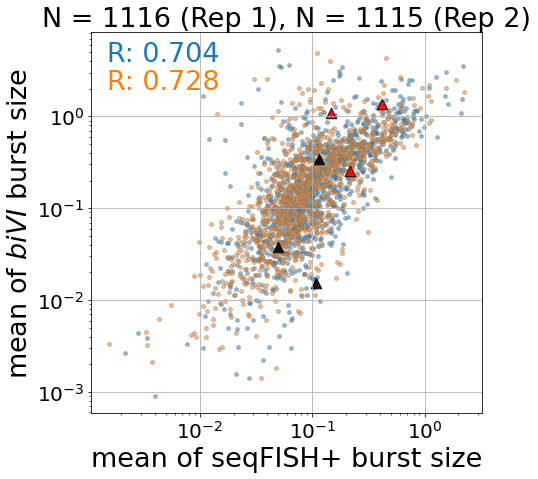

In [70]:
# Mean
fs=27
save_path=True
fig,ax = plt.subplots(1,1,figsize=(7,7))

correlation_,p = pearsonr(np.log(np.mean(es_burst_sizes_subset1 ,axis=0)),np.log(np.mean(bs_biVI,axis=0)))
plt.scatter(np.mean(es_burst_sizes_subset1 ,axis=0),np.mean(bs_biVI,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5,
            label='Rep 1')
ax.set_xlabel('mean of seqFISH+ burst size',fontsize=fs)
ax.set_ylabel('mean of $biVI$ burst size',fontsize=fs)
ax.set_title(f'N = {len(np.mean(es_burst_sizes_subset1 ,axis=0))} (Rep 1), N = {len(np.mean(es_burst_sizes_subset2 ,axis=0))} (Rep 2)',fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,4),
            fontsize=fs,color=sns.color_palette()[0])
ax.grid('lightgray')

correlation_,p = pearsonr(np.log(np.mean(es_burst_sizes_subset2 ,axis=0)),np.log(np.mean(bs_biVI2,axis=0)))
plt.scatter(np.mean(es_burst_sizes_subset2 ,axis=0),np.mean(bs_biVI2,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5,
            label='Rep 2')
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,2),
            fontsize=fs,color=sns.color_palette()[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# scatter marker genes
plt.scatter(np.mean(es_burst_sizes_subset1 ,axis=0)[mg_filt1],np.mean(bs_biVI,axis=0)[mg_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'red',
            label = 'mESC marker genes',
            )

plt.scatter(np.mean(es_burst_sizes_subset1,axis=0)[epithelial_filt1],np.mean(bs_biVI,axis=0)[epithelial_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'black',
            label = 'epithelial marker genes',
            )
# ax.legend(fontsize=20,bbox_to_anchor=(1.,.7))


#plt.suptitle('Adjusted intron spots',fontsize=28)

# if save_path:
#     plt.savefig('results/biVI_on_seqFISH_vs_seqFISH_burst_size_adj_introns',dpi=300,bbox_inches='tight')

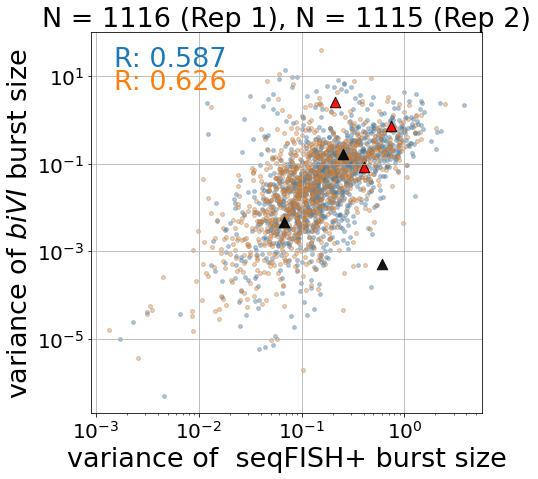

In [69]:
# VARIANCE
fs=27
save_path=True
fig,ax = plt.subplots(1,1,figsize=(7,7))

alpha = 0.4

correlation_,p = pearsonr(np.log(np.var(es_burst_sizes_subset1 ,axis=0)),np.log(np.var(bs_biVI,axis=0)))
plt.scatter(np.var(es_burst_sizes_subset1 ,axis=0),np.var(bs_biVI,axis=0),s=15,
            edgecolor='gray',
            alpha=alpha,
            label='Rep 1')
ax.set_xlabel('variance of  seqFISH+ burst size',fontsize=fs)
ax.set_ylabel('variance of $biVI$ burst size',fontsize=fs)
ax.set_title(f'N = {len(np.var(es_burst_sizes_subset1 ,axis=0))} (Rep 1), N = {len(np.var(es_burst_sizes_subset2 ,axis=0))} (Rep 2)',fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,17),
            fontsize=fs,color=sns.color_palette()[0])
ax.grid('lightgray')

correlation_,p = pearsonr(np.log(np.var(es_burst_sizes_subset2 ,axis=0)),np.log(np.var(bs_biVI2,axis=0)))
plt.scatter(np.var(es_burst_sizes_subset2 ,axis=0),np.var(bs_biVI2,axis=0),s=15,
            edgecolor='gray',
            alpha=alpha,
            label='Rep 2')
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.15*10**-2,5),
            fontsize=fs,color=sns.color_palette()[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);


# scatter marker genes
plt.scatter(np.var(es_burst_sizes_subset1 ,axis=0)[mg_filt1],np.var(bs_biVI,axis=0)[mg_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'red',
            label = 'mESC marker genes',
            )

plt.scatter(np.var(es_burst_sizes_subset1,axis=0)[epithelial_filt1],np.var(bs_biVI,axis=0)[epithelial_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'black',
            label = 'epithelial marker genes',
            )
# ax.legend(fontsize=20,bbox_to_anchor=(1.,.7))

# if save_path:
#     plt.savefig('results/biVI_on_seqFISH_vs_seqFISH_burst_size_adj_introns',dpi=300,bbox_inches='tight')

In [ ]:
print('Takei, adjusted introns')
print('mESC marker genes:')
print(parameters['gene_name'][mg_filt1])
print('avg seqFISH burstsize',np.mean(es_burst_sizes_subset1,axis=0)[mg_filt1])
print('avg biVI burstsize',np.mean(bs_biVI,axis=0)[mg_filt1])
print('---------')
print('epithelial marker genes:')
print(parameters['gene_name'][epithelial_filt1])
print('avg seqFISH burstsize',np.mean(es_burst_sizes_subset1,axis=0)[epithelial_filt1])
print('avg biVI burstsize',np.mean(bs_biVI,axis=0)[epithelial_filt1])

--------

# Repeating analysis and inference on NMuMG cultured cells

In [ ]:
!ls ../data/E14_rep1/transcriptomic-data/NMuMG-replicate1

In [ ]:
# load in data

count_dir = '../data/E14_rep1/transcriptomic-data/NMuMG-replicate1/'
nm_intron_raw = pd.read_csv(os.path.join(count_dir,'NMuMG-replicate1-intron-seqFISH-ch2.csv'))
nm_exon_raw = pd.read_csv(os.path.join(count_dir,'NMuMG-replicate1-mRNA-seqFISH-ch1.csv'))



# add unique ids
nm_intron_raw['unique_id'] = 'cell' + nm_intron_raw['cellID'].astype(str)+'_fov'+nm_intron_raw['fov'].astype('str')
nm_exon_raw['unique_id'] = 'cell' + nm_exon_raw ['cellID'].astype(str)+'_fov'+nm_exon_raw['fov'].astype('str')

In [ ]:
# subset reads, for now work with replicate 1
mask = nm_exon_raw['geneID'].isin(nm_intron_raw['geneID'].unique())
nm_exon_subset = nm_exon_raw[mask]

mask = nm_intron_raw['geneID'].isin(nm_exon_raw['geneID'].unique())
nm_intron_subset = nm_intron_raw[mask]


In [ ]:
nm_intron_counts = get_count_matrix(nm_intron_subset)
nm_exon_counts = get_count_matrix(nm_exon_subset)
nm_adjusted_intron_counts = get_adjusted_count_matrix(nm_intron_subset)

In [ ]:
nm_burst_sizes_subset = get_burst_size_per_cell(nm_intron_subset)

### Fit **biVI**


Without adjusting for intensity.

In [ ]:
# create anndata, first with rep1
adata_u = anndata.AnnData(csr_matrix(nm_intron_counts, dtype=np.float32))
adata_s = anndata.AnnData(csr_matrix(nm_exon_counts, dtype=np.float32))

adata_u.var['Spliced'] = False
adata_s.var['Spliced'] = True

adata_1 = anndata.concat([adata_u,adata_s],axis=1)
adata_1.layers["counts"] = adata_1.X.copy() # preserve counts
adata_1.obs = adata_u.obs.copy()

# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata_1,layer="counts")

In [ ]:
model = biVI.biVI(adata_1,mode='Bursty',**model_args)

In [ ]:
model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

In [ ]:
# get parameters
parameters = model.get_likelihood_parameters()
bs_biVI = parameters['burst_size']

# save parameters and counts
parameters['seqFISH_burst_size'] = nm_burst_sizes_subset,
parameters['gene_name'] = nm_intron_subset['geneID'].unique()
parameters['cell_id'] = nm_intron_subset['unique_id'].unique()
parameters['intron_counts'] = nm_intron_counts
parameters['exon_counts'] = nm_exon_counts



# and save
with open('../results/NMuMG_rep1_seqFISH_biVI_parameters_raw_introns_subset','wb') as file:
    pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)

Same, but with adjusted introns.

In [ ]:
# create anndata, first with rep1
adata_u = anndata.AnnData(csr_matrix(nm_adjusted_intron_counts, dtype=np.float32))
adata_s = anndata.AnnData(csr_matrix(nm_exon_counts, dtype=np.float32))

adata_u.var['Spliced'] = False
adata_s.var['Spliced'] = True

adata_1 = anndata.concat([adata_u,adata_s],axis=1)
adata_1.layers["counts"] = adata_1.X.copy() # preserve counts
adata_1.obs = adata_u.obs.copy()

# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata_1,layer="counts")

In [ ]:
model = biVI.biVI(adata_1,mode='Bursty',**model_args)
model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

In [ ]:
# get parameters
parameters = model.get_likelihood_parameters()
bs_biVI = parameters['burst_size']

# save parameters and counts
parameters['seqFISH_burst_size'] = nm_burst_sizes_subset,
parameters['gene_name'] = nm_intron_subset['geneID'].unique()
parameters['cell_id'] = nm_intron_subset['unique_id'].unique()
parameters['adjusted_intron_counts'] = nm_adjusted_intron_counts
parameters['exon_counts'] = nm_exon_counts



# and save
with open('../results/NMuMG_rep1_seqFISH_biVI_parameters_adjusted_introns_subset','wb') as file:
    pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)

## Plot NMuMG inferred parameters

In [ ]:
# load in to plot

# and save
with open('../results/NMuMG_rep1_seqFISH_biVI_parameters_raw_introns_subset','rb') as file:
    parameters = pickle.load(file)
    
nm_burst_sizes_subset1 = parameters['seqFISH_burst_size'][0]
nm_bs_biVI = parameters['burst_size']


In [ ]:
mg_filt1 = [mg in es_MG for mg in parameters['gene_name']]
epithelial_filt1 = [mg in epithelial_MG for mg in parameters['gene_name']]

print('mESC marker genes:')
for mg in es_MG:
    if mg in parameters['gene_name']:
        print(mg)

print('-------') 
print('epithelial marker genes:')  
for mg in epithelial_MG:
    if mg in parameters['gene_name']:
        print(mg)

In [ ]:
fs=27
save_path=True
fig,ax = plt.subplots(1,1,figsize=(7,7))


correlation_,p = pearsonr(np.log(np.mean(nm_burst_sizes_subset1 ,axis=0)),np.log(np.mean(nm_bs_biVI,axis=0)))
plt.scatter(np.mean(nm_burst_sizes_subset1,axis=0),np.mean(nm_bs_biVI,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5)
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.23*10**-2,5),
            fontsize=fs,color=sns.color_palette()[0])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('average seqFISH reported burst size',fontsize=fs)
ax.set_ylabel('average $biVI$ burst size',fontsize=fs)
ax.set_title(f'N = {len(np.mean(nm_burst_sizes_subset1 ,axis=0))}',fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')

ax.grid('lightgray')

# scatter marker genes
plt.scatter(np.mean(nm_burst_sizes_subset1 ,axis=0)[mg_filt1],np.mean(nm_bs_biVI,axis=0)[mg_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'red',
            label = 'mESC marker genes',
            )

plt.scatter(np.mean(nm_burst_sizes_subset1,axis=0)[epithelial_filt1],np.mean(nm_bs_biVI,axis=0)[epithelial_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'black',
            label = 'epithelial marker genes',
            )
# ax.legend(fontsize=20,bbox_to_anchor=(1.,.7))


plt.suptitle('Raw intron spots',fontsize=28)

# if save_path:
#     plt.savefig('results/NMuMG_biVI_on_seqFISH_vs_seqFISH_burst_size_raw_introns',dpi=300,bbox_inches='tight')

In [ ]:
print('Takei, NMuMG raw introns')
print('mESC marker genes:')
print(parameters['gene_name'][mg_filt1])
print('avg seqFISH burstsize',np.mean(nm_burst_sizes_subset1,axis=0)[mg_filt1])
print('avg biVI burstsize',np.mean(nm_bs_biVI,axis=0)[mg_filt1])
print('---------')
print('epithelial marker genes:')
print(parameters['gene_name'][epithelial_filt1])
print('avg seqFISH burstsize',np.mean(nm_burst_sizes_subset1,axis=0)[epithelial_filt1])
print('avg biVI burstsize',np.mean(nm_bs_biVI,axis=0)[epithelial_filt1])

### Same for adjusted introns.

In [ ]:
# load in to plot

# and save
with open('../results/NMuMG_rep1_seqFISH_biVI_parameters_adjusted_introns_subset','rb') as file:
    parameters = pickle.load(file)
    
nm_burst_sizes_subset1 = parameters['seqFISH_burst_size'][0]
nm_bs_biVI = parameters['burst_size']


In [ ]:
mg_filt1 = [mg in es_MG for mg in parameters['gene_name']]
epithelial_filt1 = [mg in epithelial_MG for mg in parameters['gene_name']]

print('mESC marker genes:')
for mg in es_MG:
    if mg in parameters['gene_name']:
        print(mg)

print('-------') 
print('epithelial marker genes:')  
for mg in epithelial_MG:
    if mg in parameters['gene_name']:
        print(mg)

In [ ]:
fs=27
save_path=True
fig,ax = plt.subplots(1,1,figsize=(7,7))


correlation_,p = pearsonr(np.log(np.mean(nm_burst_sizes_subset1 ,axis=0)),np.log(np.mean(nm_bs_biVI,axis=0)))
plt.scatter(np.mean(nm_burst_sizes_subset1,axis=0),np.mean(nm_bs_biVI,axis=0),s=15,
            edgecolor='gray',
            alpha=0.5)
# ax[1].set_xlabel('seqFISH reported burstsize',fontsize=fs)
# ax[1].set_ylabel('$biVI$ burstsize',fontsize=fs)
# ax[1].set_title(f'E14 Rep2',fontsize=fs)
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax.annotate(f'R: {correlation_:.3f}',(0.23*10**-2,11),
            fontsize=fs,color=sns.color_palette()[0])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('average seqFISH reported burst size',fontsize=fs)
ax.set_ylabel('average $biVI$ burst size',fontsize=fs)
ax.set_title(f'N = {len(np.mean(nm_burst_sizes_subset1 ,axis=0))}',fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid('lightgray')

# scatter marker genes
plt.scatter(np.mean(nm_burst_sizes_subset1 ,axis=0)[mg_filt1],np.mean(nm_bs_biVI,axis=0)[mg_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'red',
            label = 'mESC marker genes',
            )

plt.scatter(np.mean(nm_burst_sizes_subset1,axis=0)[epithelial_filt1],np.mean(nm_bs_biVI,axis=0)[epithelial_filt1],
            s=110,
            marker='^',
            edgecolor='black',
            alpha=0.9,
            color = 'black',
            label = 'epithelial marker genes',
            )
ax.legend(fontsize=20,bbox_to_anchor=(1.,.7))


plt.suptitle('Adjusted intron spots',fontsize=28)

# if save_path:
#     plt.savefig('results/NMuMG_biVI_on_seqFISH_vs_seqFISH_burst_size_adjusted_introns',dpi=300,bbox_inches='tight')

In [ ]:
print('Takei, NMuMG adjusted introns')
print('mESC marker genes:')
print(parameters['gene_name'][mg_filt1])
print('avg seqFISH burstsize',np.mean(nm_burst_sizes_subset1,axis=0)[mg_filt1])
print('avg biVI burstsize',np.mean(nm_bs_biVI,axis=0)[mg_filt1])
print('---------')
print('epithelial marker genes:')
print(parameters['gene_name'][epithelial_filt1])
print('avg seqFISH burstsize',np.mean(nm_burst_sizes_subset1,axis=0)[epithelial_filt1])
print('avg biVI burstsize',np.mean(nm_bs_biVI,axis=0)[epithelial_filt1])